# Keras based GRU Network

## Prepare dataset

Reformat dataset to be int format
```
caption | valence_class
caption | {negative,neutral,positive}
```

In [1]:
%matplotlib inline
import os, sys
import re
import string
import pathlib
import random
from collections import Counter, OrderedDict
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords

import hecutils.data_utils as dt
import hecutils.scoring_utils as sc
import hecutils.plotting_utils as pt

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# fix random seed for reproducibility
seed = 7

captions_root = "/home/elkhand/git-repos/human-emotions-classifier/dataset/metadata"
oasis_csv_path = "dataset/metadata/OASIS.csv"
captions_root_path = pathlib.Path(captions_root)

human_output_caption_to_label_csv_path = captions_root_path/'humanCaptionWithLabeldf.csv'
human_caption_csv_path = captions_root_path/'captions.csv'
neutralLow = 3.0 
neutralHigh = 5.0
dt.create_caption_to_label(oasis_csv_path,human_caption_csv_path, human_output_caption_to_label_csv_path,neutralLow, neutralHigh)

auto_output_caption_to_label_csv_path = captions_root_path/'autoCaptionWithLabeldf.csv'
auto_caption_csv_path = captions_root_path/'auto_generated_captions.csv'
neutralLow = 3.0 
neutralHigh = 5.0
dt.create_caption_to_label(oasis_csv_path,auto_caption_csv_path, auto_output_caption_to_label_csv_path,neutralLow, neutralHigh)

None


## Set Keras to use Tensorflow GPU in the backend

In [2]:
import tensorflow as tf
from keras import backend as K

num_cores = 8
GPU=True
CPU = not GPU

if GPU:
    num_GPU = 2
    num_CPU = 8
if CPU:
    num_CPU = 1
    num_GPU = 0

config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,\
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,\
        device_count = {'CPU' : num_CPU, 'GPU' : num_GPU})
session = tf.Session(config=config)
K.set_session(session)

/home/elkhand/anaconda3/envs/cs231n/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Loading Fasttext Embeddings

You can download fasttext word vectors from here:

https://fasttext.cc/docs/en/english-vectors.html    
https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki-news-300d-1M.vec.zip
    

In [3]:
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Dense
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import GRU, Bidirectional, LSTM
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Masking
from keras.layers.core import  ActivityRegularization
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.utils import plot_model
from keras.utils import multi_gpu_model
from keras import regularizers
from keras.regularizers import L1L2
import keras
from sklearn.model_selection import KFold
import os
import io
import numpy as np
import tensorflow as tf
from gensim.models import word2vec
import pandas as pd
# from fastText import load_model
from gensim.models.keyedvectors import KeyedVectors
from keras.preprocessing import text
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import StratifiedKFold

%matplotlib inline 

def load_embedding(path):
    word2vec = {}
    with io.open(path, encoding="utf8") as f:
        for line in f:
            entries = line.rstrip().split(" ")
            word, entries = entries[0], entries[1:]
            word2vec[word] = np.array(entries).astype(np.float) # Convert String type to float
    print('embedding size : %d' % len(word2vec))
    print('embedding dimension : %s' % (word2vec['apple'].shape,))
    return word2vec
    
wordToVec = {}


fasttext_embedding_path = 'embedding/wiki-news-300d-1M.vec'
wordToVec = load_embedding(fasttext_embedding_path)



embedding size : 999995
embedding dimension : (300,)


## Results

Epoch 300/300
663/663 [==============================] - 2s 3ms/step - loss: 0.1011 - acc: 0.9789 - val_loss: 1.9239 - val_acc: 0.6426

best_val_acc:  0.7148936180358237
filename adidas-0.7149-1527322080
Total time passed for training 9.198103360335033


Label distribution:  label
negative    163
neutral     420
positive    317
Name: label, dtype: int64
max_seq_len 44

TRAIN size: 674 	 VAL size: 226
TRAIN[:5]: [0 1 2 5 6] 	 VAL[:5]: [ 3  4  7 13 33]
TRAIN[-5:]: [893 894 896 898 899] 	 VAL[-5:]: [886 890 891 895 897]
[[ 0.0134  0.0171 -0.0344 ...  0.1915  0.2418  0.0458]
 [-0.3155 -0.0408 -0.2793 ...  0.1258  0.024  -0.219 ]
 [ 0.0681 -0.0378 -0.054  ...  0.1112 -0.1476 -0.0091]
 ...
 [ 0.      0.      0.     ...  0.      0.      0.    ]
 [ 0.      0.      0.     ...  0.      0.      0.    ]
 [ 0.      0.      0.     ...  0.      0.      0.    ]]
[1. 0. 0.]
Train label distribution:  label
negative    122
neutral     315
positive    237
Name: label, dtype: int64
Val label distribution:  label
negative     41
neutral     105
positive     80
Name: label, dtype: int64
max_seq_len 44
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_56 (Masking)      

674/674 [==============================] - 2s 3ms/step - loss: 0.4706 - acc: 0.7908 - val_loss: 0.6831 - val_acc: 0.7301
Epoch 50/100
674/674 [==============================] - 2s 3ms/step - loss: 0.4892 - acc: 0.7997 - val_loss: 0.6744 - val_acc: 0.7389
Epoch 51/100
674/674 [==============================] - 2s 3ms/step - loss: 0.4901 - acc: 0.7819 - val_loss: 0.6689 - val_acc: 0.7345
Epoch 52/100
674/674 [==============================] - 2s 3ms/step - loss: 0.4623 - acc: 0.7864 - val_loss: 0.6835 - val_acc: 0.7301
Epoch 53/100
674/674 [==============================] - 2s 3ms/step - loss: 0.4304 - acc: 0.8190 - val_loss: 0.6715 - val_acc: 0.7301
Epoch 54/100
674/674 [==============================] - 2s 3ms/step - loss: 0.4373 - acc: 0.8071 - val_loss: 0.6822 - val_acc: 0.7389
Epoch 55/100
674/674 [==============================] - 2s 3ms/step - loss: 0.4580 - acc: 0.8027 - val_loss: 0.6785 - val_acc: 0.7212
Epoch 56/100
674/674 [==============================] - 2s 3ms/step - loss:

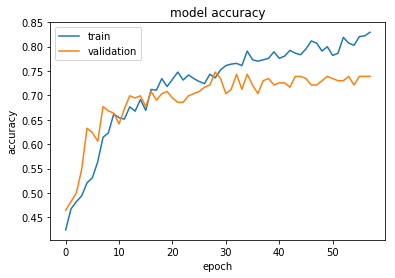

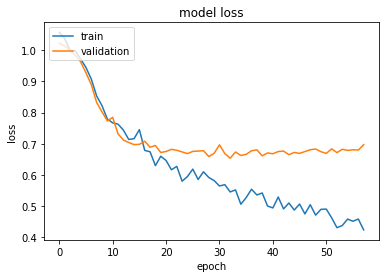

Time passed for training 2.81238538424174

TRAIN size: 675 	 VAL size: 225
TRAIN[:5]: [0 1 2 3 4] 	 VAL[:5]: [ 5  6  8  9 14]
TRAIN[-5:]: [892 894 895 897 899] 	 VAL[-5:]: [876 884 893 896 898]
[[ 0.0134  0.0171 -0.0344 ...  0.1915  0.2418  0.0458]
 [-0.3155 -0.0408 -0.2793 ...  0.1258  0.024  -0.219 ]
 [ 0.0681 -0.0378 -0.054  ...  0.1112 -0.1476 -0.0091]
 ...
 [ 0.      0.      0.     ...  0.      0.      0.    ]
 [ 0.      0.      0.     ...  0.      0.      0.    ]
 [ 0.      0.      0.     ...  0.      0.      0.    ]]
[1. 0. 0.]
Train label distribution:  label
negative    122
neutral     315
positive    238
Name: label, dtype: int64
Val label distribution:  label
negative     41
neutral     105
positive     79
Name: label, dtype: int64
max_seq_len 44
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_57 (Masking)         (None, None, 300)         0         
__________________________________

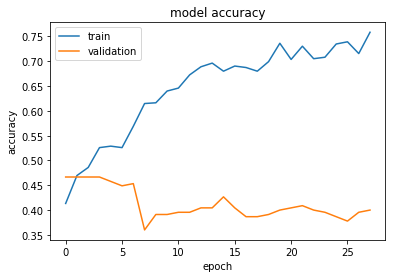

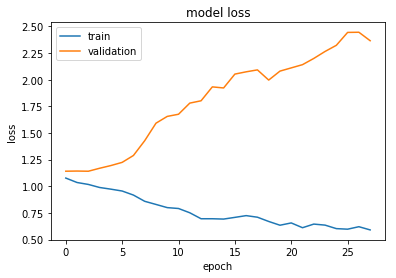

Time passed for training 1.7503114581108092

TRAIN size: 675 	 VAL size: 225
TRAIN[:5]: [3 4 5 6 7] 	 VAL[:5]: [ 0  1  2 11 15]
TRAIN[-5:]: [893 895 896 897 898] 	 VAL[-5:]: [881 883 888 894 899]
[[ 0.0134  0.0171 -0.0344 ...  0.1915  0.2418  0.0458]
 [-0.083   0.1102  0.0196 ...  0.1866  0.0824  0.1139]
 [-0.0733  0.0793  0.0537 ... -0.0042  0.2184 -0.0594]
 ...
 [ 0.      0.      0.     ...  0.      0.      0.    ]
 [ 0.      0.      0.     ...  0.      0.      0.    ]
 [ 0.      0.      0.     ...  0.      0.      0.    ]]
[1. 0. 0.]
Train label distribution:  label
negative    122
neutral     315
positive    238
Name: label, dtype: int64
Val label distribution:  label
negative     41
neutral     105
positive     79
Name: label, dtype: int64
max_seq_len 44
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_58 (Masking)         (None, None, 300)         0         
________________________________

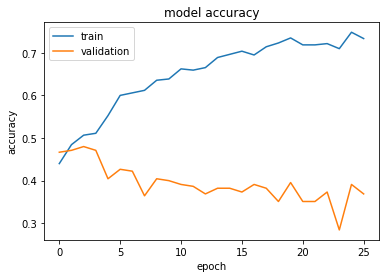

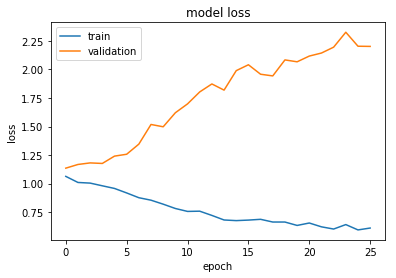

Time passed for training 1.715271516640981

TRAIN size: 676 	 VAL size: 224
TRAIN[:5]: [0 1 2 3 4] 	 VAL[:5]: [10 12 20 22 24]
TRAIN[-5:]: [895 896 897 898 899] 	 VAL[-5:]: [871 880 887 889 892]
[[ 0.0134  0.0171 -0.0344 ...  0.1915  0.2418  0.0458]
 [-0.3155 -0.0408 -0.2793 ...  0.1258  0.024  -0.219 ]
 [ 0.0681 -0.0378 -0.054  ...  0.1112 -0.1476 -0.0091]
 ...
 [ 0.      0.      0.     ...  0.      0.      0.    ]
 [ 0.      0.      0.     ...  0.      0.      0.    ]
 [ 0.      0.      0.     ...  0.      0.      0.    ]]
[1. 0. 0.]
Train label distribution:  label
negative    123
neutral     315
positive    238
Name: label, dtype: int64
Val label distribution:  label
negative     40
neutral     105
positive     79
Name: label, dtype: int64
max_seq_len 44
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_59 (Masking)         (None, None, 300)         0         
_________________________________

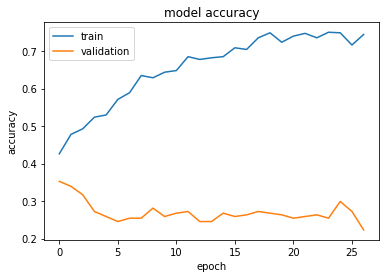

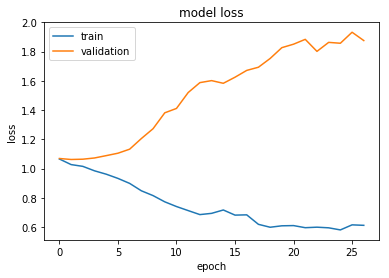

Time passed for training 1.7806206703186036
Cross-validation results: 0.51% (+/- 0.14%)
Total time passed for training 8.058796989917756


In [21]:
import nltk
from nltk.corpus import stopwords
from keras.layers.core import  ActivityRegularization
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers.core import Flatten
from keras.layers import GRU, Bidirectional, LSTM

stop_words = set(stopwords.words('english'))

def plot_model_accuracy(history):
    """plot acc and loss for train and val"""
    filename = "hec" 
    filename = generate_model_name(filename + "-acc", max(history.history['val_acc']))
    fig = plt.figure()
    print(history.history.keys())
    print("best_val_acc", max(history.history['val_acc']))
    print("best_train_acc", max(history.history['acc']))
    print("lowest_val_loss", min(history.history['val_loss']))
    print("lowest_train_loss", min(history.history['loss']))
    #  "Accuracy"
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    fig.savefig("model/" + filename + ".png") 
    
    # "Loss"
    fig = plt.figure()
    filename = "hec" 
    filename = generate_model_name(filename + "-loss", min(history.history['val_loss']))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    fig.savefig("model/" + filename + ".png") 

def build_model(max_seq_len, num_of_classes, embedding_dim, hidden_layer_dim, dropout, recurrent_dropout, final_activation): 
    shouldUnroll = False
    model = Sequential()
    model.add(Masking(mask_value=0., input_shape=(None, embedding_dim)))
    print("max_seq_len", max_seq_len)
#     model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
#     model.add(MaxPooling1D(pool_size=2))
#     model.add(Flatten())
#     model.add(Dense(250, activation='relu'))
    
    
    # ,dropout=dropout, recurrent_dropout=recurrent_dropout
    #, unroll=shouldUnroll
#     model.add(Bidirectional(GRU(max_seq_len, return_sequences=True, recurrent_dropout=recurrent_dropout), merge_mode='concat'))
#     model.add(Bidirectional(GRU(max_seq_len // 2, return_sequences=True, recurrent_dropout=recurrent_dropout), merge_mode='concat'))
#     model.add(Bidirectional(GRU(max_seq_len // 4, dropout=dropout, recurrent_dropout=recurrent_dropout), merge_mode='concat'))    
    
    model.add(Bidirectional(GRU(12, return_sequences=True, dropout=dropout, recurrent_dropout=recurrent_dropout)))
    #model.add(Bidirectional(GRU(max_seq_len, return_sequences=True, recurrent_dropout=recurrent_dropout)))
    model.add(Bidirectional(GRU(12, dropout=dropout, recurrent_dropout=recurrent_dropout))) 
    
    
    # Adding new dense layers
#     model.add(Dense(hidden_layer_dim,  activation='relu', kernel_regularizer=regularizers.l2(0.001)))
#     model.add(Dropout(dropout))
    #model.add(ActivityRegularization(l1=0.01, l2=0.001))


    model.add(Dense(num_of_classes, activation=final_activation))
    nadamOptim = keras.optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model


def get_word_embedding(word):
    word = word.lower()
    if word in wordToVec:
        return wordToVec[word]
    else:
        return np.zeros(embedding_dimension,)
    
def get_sequence_embedding(words, max_seq_len):
    if len(words) <= max_seq_len:
        # Add padding
        x_seq = np.array([get_word_embedding(word) for word in words])
        x_seq = np.lib.pad(x_seq, ((0,max_seq_len-x_seq.shape[0]),(0,0)), 'constant')
    else:
        x_seq = []
        for i in range(max_seq_len):
            x_seq.append(get_word_embedding(words[i]))
        x_seq = np.array(x_seq)
    return x_seq
        
def convert_index_to_one_hot(y_train_index, num_of_classes):
    y_train = np.zeros((y_train_index.shape[0],num_of_classes))
    y_train[range(y_train_index.shape[0]),y_train_index] = 1
    return y_train


def generate_model_name(filename, best_acc_val):
    timestamp = str(time.time()).split(".")[0]
    best_acc_val = round(best_acc_val,4)
    filename += "-" + str(best_acc_val) + "-" + timestamp
    return filename

def get_words_withoutstopwords(words):
    
    words_without_stopwords = []
    for word in words:
        if word not in stop_words:
            words_without_stopwords.append(word)
    return words_without_stopwords

def load_dataset_StratifiedKFold(dfKFold, max_seq_len):
    sentences = []
    label_index = []
    num_of_classes = 0
    class_to_index = {}
    index_to_class = {}
    for index, row in dfKFold.iterrows():
        caption = row['caption']
        label = row['label']
        sentence = caption
        words = sentence.split(" ")
        words = get_non_stop_words(words)
        sentence_embedding = get_sequence_embedding(words, max_seq_len)
        sentences.append(sentence_embedding)
        if label in class_to_index:
            label_index.append(class_to_index[label])
        else:
            num_of_classes += 1
            class_to_index[label] = num_of_classes - 1
            index_to_class[num_of_classes - 1] = label
            label_index.append(class_to_index[label])
    X_train = np.array(sentences)
    y_train = np.array(label_index)
    return (X_train, y_train, num_of_classes)


def get_non_stop_word_count(words):
    count = 0
    for word in words:
        if word not in stop_words:
            count += 1
    return count


def get_non_stop_words(words):
    non_stop_words = []
    for word in words:
        if word not in stop_words:
            non_stop_words.append(word)
    return non_stop_words

def train_StratifiedKFold():
    """StratifiedKFold cross-validation to solve class imbalance issue"""
    df = pd.read_csv(dataset_path, sep="|")
    X = df['caption']
    y = df['label']
    print("Label distribution: ",df.groupby('label').label.count())
    max_seq_len = int(df['caption'].map(lambda x: get_non_stop_word_count(x.split())).max())
    print("max_seq_len", max_seq_len)
    # Instantiate the cross validator
    skf = StratifiedKFold(n_splits=kfold_splits, shuffle=True)
    printCnt = 5
    cvscores = []
    # Loop through the indices the split() method returns
    for index, (train_indices, val_indices) in enumerate(skf.split(X, y)):
        start = time.time()
        print("\nTRAIN size:", len(train_indices), "\t VAL size:", len(val_indices))
        print("TRAIN[:5]:", train_indices[:printCnt], "\t VAL[:5]:", val_indices[:printCnt])
        print("TRAIN[-5:]:", train_indices[-printCnt:], "\t VAL[-5:]:", val_indices[-printCnt:])
        X_train, X_val = X[train_indices], X[val_indices]
        y_train_index, y_val_index = y[train_indices], y[val_indices]
        dfTrain = pd.concat([X_train, y_train_index], axis=1)
        dfTrain.columns = ['caption', 'label']
        X_train, y_train_index, num_of_classes = load_dataset_StratifiedKFold(dfTrain, max_seq_len)
        y_train = convert_index_to_one_hot(y_train_index, num_of_classes) 
        print(X_train[0])
        print(y_train[0])
        print("Train label distribution: ",dfTrain.groupby('label').label.count())
        dfVal= pd.concat([X_val, y_val_index], axis=1)
        dfVal.columns = ['caption', 'label']
        
        X_val, y_val_index, _ = load_dataset_StratifiedKFold(dfVal,max_seq_len)
        y_val = convert_index_to_one_hot(y_val_index, num_of_classes) 
        print("Val label distribution: ",dfVal.groupby('label').label.count())
        
        model = build_model(max_seq_len,
                            num_of_classes, 
                            embedding_dim=300, 
                            hidden_layer_dim=64, 
                            dropout=0.5, 
                            recurrent_dropout=0.5,# 0.3
                            final_activation='softmax'
                            )
        plot_model(model, to_file= 'model/model.png', show_shapes=True, show_layer_names=True)#
       
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                                  factor=0.2, 
                                  patience=5, 
                                  min_lr=0.00001)
    
        history = {}
        filename = ""
        # checkpoint
        filepath="model/weights.best.h5"
        checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
        early_stopping = EarlyStopping(monitor='val_loss', patience=25)
        callbacks_list = [ checkpoint, early_stopping] # reduce_lr,
        history = model.fit(x=X_train,
                      y=y_train, 
                      batch_size=16,# 64 seems fine, 32 is better 
                      epochs=100, 
                      verbose=1, 
                      validation_data = (X_val, y_val),
                      #shuffle=True,
                      callbacks=callbacks_list)        
        val_acc_list = history.history['val_acc']
        best_val_acc =  max(val_acc_list)
        filename = "hec" 
        filename = "model/" + generate_model_name(filename, best_val_acc) + ".h5"
        os.rename(filepath, filename)
        print("Metric names: ", model.metrics_names)
        cvscores.append(best_val_acc)

        print("best_val_acc: ", best_val_acc)
        print("filename",filename)
        #plot_model(model, to_file= filename +'.png', show_shapes=True, show_layer_names=True)#
        plot_model_accuracy(history)
        end = time.time()
        print("Time passed for training", (end-start)/60)
    print("Cross-validation results: %.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
    return history


dataset_path = human_output_caption_to_label_csv_path
kfold_splits = 4
# dataset_path = auto_output_caption_to_label_csv_path


embedding_dimension = 300
class_to_index = {}
index_to_class = {}
#max_seq_len = 40
start = time.time()
history = train_StratifiedKFold() 
#dataset_path = caption_to_label_dataset_path + "/" +'human-train.csv'
#val_dataset_path = caption_to_label_dataset_path + "/" +'human-val.csv'
#history = train()
end = time.time()
print("Total time passed for training", (end-start)/60)


# K-fold cross validation

As this vanilla k-fold does not take into account the class imbalance, is not used any more.

In [5]:
# def load_dataset(file_path):
#     df = pd.read_csv(file_path, sep="|")
#     sentences = []
#     label_index = []
#     num_of_classes = 0
#     for i in range(len(df)):
#         sentence = df.iloc[:,0][i]  # first column of data frame
#         words = sentence.split(" ")
#         sentence_embedding = get_sequence_embedding(words, max_seq_len)
#         sentences.append(sentence_embedding)
#         label = df.iloc[:,1][i]  # second column of data frame
#         if label in class_to_index:
#             label_index.append(class_to_index[label])
#         else:
#             num_of_classes += 1
#             class_to_index[label] = num_of_classes - 1
#             index_to_class[num_of_classes - 1] = label
#             label_index.append(class_to_index[label])
#     X_train = np.array(sentences)
#     y_train = np.array(label_index)
#     return (X_train, y_train, num_of_classes)


# def train():
#     X_train, y_train_index, num_of_classes = load_dataset(dataset_path)
#     y_train = convert_index_to_one_hot(y_train_index, num_of_classes) 
    
#     print('X_train shape : %s' % (X_train.shape,))
#     print('y_train shape : %s' % (y_train.shape,))
#     print('number of classes : %d' % num_of_classes)
#     print(X_train[0])
#     print(y_train[0])
#     print(index_to_class)

#     X_val, y_val_index, _ = load_dataset(val_dataset_path)
#     y_val = convert_index_to_one_hot(y_val_index, num_of_classes) 
    
#     model = _build_model(num_of_classes, 
#                          embedding_dim=300, 
#                          hidden_layer_dim=64, 
# #                          dropout=0.65, 
# #                          recurrent_dropout=0.65,
#                          dropout=0.7, 
#                          recurrent_dropout=0.5,
#                          final_activation='softmax')
    
#     reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
#                                   factor=0.03, 
#                                   patience=15, 
#                                   min_lr=0.00001, verbose=1)
    
#     history = {}
#     filename = ""
#     # checkpoint
#     filepath="model/weights.best.h5"
#     checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
#     early_stopping = EarlyStopping(monitor='val_loss', patience=20)
#     callbacks_list = [ checkpoint, early_stopping] #reduce_lr, 
#     with tf.Session() as sess:
#         history = model.fit(x=X_train,
#                   y=y_train, 
#                   batch_size=32, 
#                   epochs=300, 
#                   verbose=1, 
#                   validation_data = (X_val, y_val),
#                   shuffle=True
#                   ,callbacks=callbacks_list)        
#         val_acc_list = history.history['val_acc']
#         best_val_acc =  max(val_acc_list)
#         filename = "hec" 
#         filename = "model/" + generate_model_name(filename, best_val_acc) + ".h5"
#         os.rename(filepath, filename)
    
#     best_val_acc = -1
#     val_acc_list = history.history['val_acc']
#     best_val_acc =  max(val_acc_list)
#     print("best_val_acc: ", best_val_acc)
#     #filename = generate_model_name(filename, best_val_acc)
#     print("filename",filename)
#     plot_model(model, to_file= filename +'.png', show_shapes=True, show_layer_names=True)#
#     return history



# # Not sued, as this cross validation does not take into account the class inbalance
# ## Create k-fold cross validation
# from sklearn.model_selection import KFold
# dataset_path = human_output_caption_to_label_csv_path
# class_to_index = {}
# index_to_class = {}
# kfold_splits = 5
# # dataset_path = auto_output_caption_to_label_csv_path
# def train_k_fold():
#     X, y_index, num_of_classes = load_dataset(dataset_path)
#     print('X shape : %s' % (X.shape,))
#     print('y_index shape : %s' % (y_index.shape,))
#     print('number of classes : %d' % num_of_classes)

#     y = convert_index_to_one_hot(y_index, num_of_classes) 
#     print('y shape : %s' % (y.shape,))
#     print(X[0])
#     print(y[0])
#     print(index_to_class)
    
#     kf = KFold(n_splits=kfold_splits)
#     kf.get_n_splits(X)
#     print(kf)  
#     cvscores = []
#     printCnt = 5
#     for train_index, val_index in kf.split(X):
#         print("TRAIN:", len(train_index), "VAL:", len(val_index))
#         print("TRAIN:", train_index[:printCnt], "VAL:", val_index[:printCnt])
#         print("TRAIN:", train_index[-printCnt:], "VAL:", val_index[-printCnt:])
#         X_train, X_val = X[train_index], X[val_index]
#         y_train, y_val = y[train_index], y[val_index]
#         model = _build_model(num_of_classes, 
#                              embedding_dim=300, 
#                              hidden_layer_dim=64, 
#                              dropout=0.5, 
#                              recurrent_dropout=0.5,
#                              final_activation='softmax')

#         reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
#                                       factor=0.03, 
#                                       patience=15, 
#                                       min_lr=0.00001, verbose=1)

#         history = {}
#         filename = ""
#         # checkpoint
#         filepath="model/weights.best.h5"
#         #checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
#         #early_stopping = EarlyStopping(monitor='val_loss', patience=20)
#         #callbacks_list = [ checkpoint, early_stopping] #reduce_lr, 
#         history = model.fit(x=X_train,
#                           y=y_train, 
#                           batch_size=32, 
#                           epochs=100, 
#                           verbose=1
#                           )# ,callbacks=callbacks_list        

#         # evaluate the model
#         scores = model.evaluate(X[val_index], y[val_index], verbose=0)
#         print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
#         cvscores.append(scores[1] * 100)
#     print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
#     return cvscores
# #         val_acc_list = history.history['val_acc']
# #         best_val_acc =  max(val_acc_list)
# #         filename = "hec" 
# #         filename = "model/" + generate_model_name(filename, best_val_acc) + ".h5"
# #         os.rename(filepath, filename)

# #         best_val_acc = -1
# #         val_acc_list = history.history['val_acc']
# #         best_val_acc =  max(val_acc_list)
# #         print("best_val_acc: ", best_val_acc)
# #         #filename = generate_model_name(filename, best_val_acc)
# #         print("filename",filename)
# #         plot_model(model, to_file= filename +'.png', show_shapes=True, show_layer_names=True)#
# #         return history

# cvscores = train_k_fold()

## Create Train and Val set

Not used, as using Stratified k-fold cross-validation

In [6]:
# from shutil import rmtree

# trainValSplitRatio = 0.75

# def delete_file(filePath):
#     if os.path.isfile(filePath):
#         os.remove(filePath)

# def create_train_dev_set(isRunningForHumanCaption, dataset_path, delimeter="|"):
#     if isRunningForHumanCaption:
#         caption_csv_path = human_output_caption_to_label_csv_path
#         prefix = "human"
#     else:
#         caption_csv_path = auto_output_caption_to_label_csv_path
#         prefix = "auto"
    
    
#     dataset_groups=["train", "val"]
#     if not os.path.isdir(dataset_path):
#         os.makedirs(dataset_path)

#     captionToLabelDf = dt.read_caption_to_label_csv_into_dataframe(caption_csv_path)
#     captionToLabelDf.shape
#     captionToLabelDf.head()

#     random.seed(1)
#     trainCount = 0
#     valCount = 0
#     for index, row in captionToLabelDf.iterrows():
#         caption = row['caption']
#         label = row['label']
#         prob = random.uniform(0, 1)
#         if prob > trainValSplitRatio:
#             dGroup = "val"
#             valCount += 1
#         else:
#             dGroup = "train"
#             trainCount += 1
#         filename = prefix + "-" + dGroup + ".csv"
#         filePath = dataset_path + filename
#         if index == 0:
#             trainFile = prefix + "-" + "train" + ".csv"
#             delete_file(dataset_path + trainFile)
#             valFile = prefix + "-" + "val" + ".csv"
#             delete_file(dataset_path + valFile)
            
#         with open(filePath,  'a', encoding="utf8") as f:
#             f.write(caption + delimeter + label + "\n")
#     print("Train count: ", trainCount)
#     print("Val count: ", valCount)

    
# caption_to_label_dataset_path = "dataset/caption-lstm/"

# # Create Train and Val set for human generated captions
# isRunningForHumanCaption = True
# create_train_dev_set(isRunningForHumanCaption, caption_to_label_dataset_path)

# # Create Train and Val set for auto generated captions
# isRunningForHumanCaption = False
# create_train_dev_set(isRunningForHumanCaption, caption_to_label_dataset_path)